# ✅ Asynkron Solana-pipeline med støtte for transaction versions

📦 Bruker `aiohttp` for å sende rå RPC-kall til Solana og håndtere `maxSupportedTransactionVersion`

🔗 Referanse: [ChatGPT-samtale](https://chatgpt.com/share/e/688d1ed5-04f0-800f-a579-80b2a559e77c)  
👤 GitHub-bruker: `sac-marius`  
🛠️ Bruker `asyncio` + `aiohttp` for å hente blokker uten feil knyttet til transaksjonsversjoner

---


In [5]:
# Installer nødvendige pakker
!pip install aiohttp pandas pyarrow tqdm nest_asyncio


In [6]:
import aiohttp
import asyncio
import nest_asyncio
import pandas as pd
from tqdm.notebook import tqdm
import time
import json

nest_asyncio.apply()


In [7]:
RPC_URL = "https://api.mainnet-beta.solana.com"

HEADERS = {
    "Content-Type": "application/json"
}

async def fetch_block(session, slot):
    payload = {
        "jsonrpc": "2.0",
        "id": slot,
        "method": "getBlock",
        "params": [
            slot,
            {
                "maxSupportedTransactionVersion": 0
            }
        ]
    }

    try:
        async with session.post(RPC_URL, headers=HEADERS, data=json.dumps(payload)) as resp:
            res = await resp.json()
            result = res.get("result", None)
            if not result:
                return []

            block_time = result.get("blockTime")
            txs = result.get("transactions", [])
            parsed = []
            for tx in txs:
                message = tx['transaction']['message']
                meta = tx['meta']
                if not meta or not meta.get('postBalances'):
                    continue

                accounts = message['accountKeys']
                from_addr = accounts[0]
                to_addr = accounts[1] if len(accounts) > 1 else None

                lamports = (
                    meta['postBalances'][1] - meta['preBalances'][1]
                    if len(meta['postBalances']) > 1 else 0
                )

                parsed.append({
                    'slot': slot,
                    'timestamp': block_time,
                    'tx_signature': tx['transaction']['signatures'][0],
                    'from_address': from_addr,
                    'to_address': to_addr,
                    'lamports': lamports
                })
            return parsed
    except Exception as e:
        print(f"⚠️ Feil på slot {slot}: {e}")
        return []


In [8]:
async def main():
    # Manuelt hent siste slot fra RPC hvis ønskelig
    latest_slot = 357232500  # Sett manuelt om ønskelig
    n = 1000
    slots = list(range(latest_slot - n, latest_slot))

    all_results = []
    start = time.time()

    connector = aiohttp.TCPConnector(limit=10)  # 10 samtidige kall
    async with aiohttp.ClientSession(connector=connector) as session:
        tasks = [fetch_block(session, slot) for slot in slots]
        for f in tqdm(asyncio.as_completed(tasks), total=len(tasks), desc="Henter blokker"):
            result = await f
            all_results.extend(result)

    df = pd.DataFrame(all_results)
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
    df.to_parquet("solana_blocks_async.parquet", index=False, compression='snappy')

    print("✅ Lagret som 'solana_blocks_async.parquet'")
    print(f"⏱️ Total tid: {time.time() - start:.2f} sekunder")

await main()


Henter blokker:   0%|          | 0/1000 [00:00<?, ?it/s]

✅ Lagret som 'solana_blocks_async.parquet'
⏱️ Total tid: 23.07 sekunder


In [14]:
import pandas as pd

df = pd.read_parquet("solana_blocks_async.parquet")
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
df.head()


,slot,timestamp,tx_signature,from_address,to_address,lamports
0,357231546,2025-08-01 20:13:50,3BqFNN4j8uxAvttyQqJZ4429mpFKvYWjbNUXXxYrFZLUCb...,8kY43bWXzoLDiiqPrK5NTUewLSHFEMZLrJVdWTsKsRs,m2SoUqbGsjLttcnbPV8YJ5B3PUSsgL7ZH2aJTyRM3FG,3684337650
1,357231546,2025-08-01 20:13:50,AnoFaYMu3QjjmmAXxoK7vyqLkJFk2iX2ctoCrdXoS9QJtk...,BaMxN7SQGfFezhcNWmYzJpBbyjDixCPuPa3ZbdMsvKVE,4ugGD1ceSJyPZxP3SEvAEdicrZw6NYfdNterEC4oyYZU,0
2,357231546,2025-08-01 20:13:50,5JJA74iYFKFqWgaRFWq5pMvudJVxNopkEJobEW7ZtQmBKq...,Au4qmXKEz4H7DbkjqnFoUh7tWeMoPj3jWKNoNk6hvuRe,3AVi9Tg9Uo68tJfuvoKvqKNWKkC5wPdSSdeBnizKZ6jT,25000
3,357231546,2025-08-01 20:13:50,5XYgwos3W7RVGeE14w2td2tTpWWN2xqtR8cHVoQaD4uSEC...,7Quv653RJ2gC89rQmAknweYs8DSZNuDiWUvJDEM4RUwc,Au4qmXKEz4H7DbkjqnFoUh7tWeMoPj3jWKNoNk6hvuRe,980000
4,357231546,2025-08-01 20:13:50,2FHDaRcJQon1i5MVPJ4wT6sNcVhe7pUa61MDu3LGWKDS7f...,6vkLfpHPDxBVzXEzmL5HCPn2aqQYzGzEfSYxSWVCvFEy,Au4qmXKEz4H7DbkjqnFoUh7tWeMoPj3jWKNoNk6hvuRe,980000


In [20]:
df['interval'] = df['timestamp'].dt.floor('1min')


In [21]:
tx_per_interval = df.groupby('interval').size().reset_index(name='num_transactions')


In [22]:
df['all_addresses'] = df['from_address'].astype(str) + ',' + df['to_address'].astype(str)
df_exploded = df.assign(addresses=df['all_addresses'].str.split(',')).explode('addresses')

unique_users = df_exploded.groupby('interval')['addresses'].nunique().reset_index(name='num_unique_users')


In [23]:
summary = pd.merge(tx_per_interval, unique_users, on='interval')
summary


,interval,num_transactions,num_unique_users
0,2025-08-01 20:13:00,1410,2542
1,2025-08-01 20:15:00,3325,3175
2,2025-08-01 20:16:00,2461,2596
3,2025-08-01 20:17:00,1634,2654


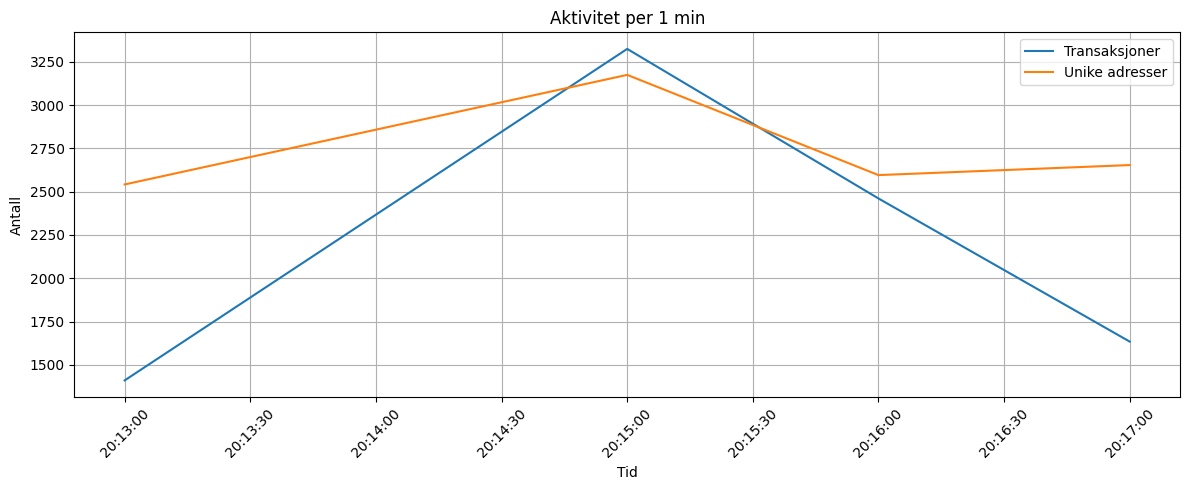

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(summary['interval'], summary['num_transactions'], label='Transaksjoner')
plt.plot(summary['interval'], summary['num_unique_users'], label='Unike adresser')
plt.xlabel("Tid")
plt.ylabel("Antall")
plt.title("Aktivitet per 1 min")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
